## Ridge Regression with Featurization

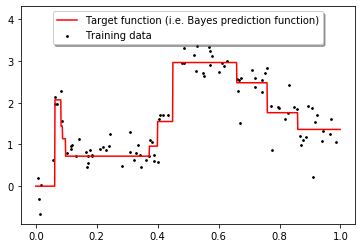

In [203]:
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle


def step_fn_generator(stepLoc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= stepLoc] = 1
        return ret
    return f

def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f

def get_target_and_featurizer(num_basis_fns = 100, num_nonzero = 10, coefs_true=None):
    # We'll create a basis of step functions on the interval [0,1]. We'll then
    # construct a linear combination of these step functions to be our target
    # function. We'll construct a function to "featurize" an input in [0,1]
    # into the evaluations of all functions in the basis on the input.
    # Optionally: If coefs_true is provided, they will be used to generate
    # target_fn and featurize.
    # Construct basis, to be used for generating target function

    if coefs_true is not None:
        num_basis_fns = len(coefs_true)
    else:
        nonzero_indices = np.random.choice(num_basis_fns, num_nonzero)
        coefs_true = np.zeros(num_basis_fns)
        coefs_true[nonzero_indices] = np.random.randn(num_nonzero)

    all_basis_fns = [step_fn_generator(stepLoc=s)
                     for s in np.linspace(0, 1, num_basis_fns, endpoint=False)]

    # Construct target function (the Bayes prediction function)
    target_fn = linear_comb_generator(all_basis_fns, coefs_true)

    def featurize(x):
        n = len(x)
        # Featurize input values in [0,1]
        X_ftrs = np.empty((n, num_basis_fns))
        for ftr_num in range(num_basis_fns):
            X_ftrs[:, ftr_num] = all_basis_fns[ftr_num](x)
        return X_ftrs

    return target_fn, coefs_true, featurize

def generate_data(target_fn, n=1000, noise_scale=.25, tdof=6):
    # Construct dataset
    x = np.sort(np.random.rand(n)) #chooses uniformly from [0,1)
    y_target = target_fn(x)
    y = y_target + noise_scale * np.random.standard_t(tdof,n)
    return x, y

def get_data_splits(x, y, test_frac=.2):
    ## Based on https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb
    n = len(y)
    shuffled_indices = np.random.permutation(n)
    n_test = int(n * test_frac)
    n_train = n - n_test
    indices_test = shuffled_indices[:n_test]
    indices_train = shuffled_indices[n_test:]
    y_train = y[indices_train]
    x_train = x[indices_train]
    y_test = y[indices_test]
    x_test = x[indices_test]
    return x_train, y_train, x_test, y_test

def generate_problem(n=200, num_basis_fns=400, num_nonzero=10, noise_scale=.25, tdof=6, test_frac=.2, write_problem=False, file_name="lasso_data.pickle"):
    target_fn, coefs_true, featurize = get_target_and_featurizer(num_basis_fns, num_nonzero)
    x, y = generate_data(target_fn, n, noise_scale, tdof)
    x_train, y_train, x_test, y_test = get_data_splits(x, y, test_frac)

    if write_problem:
        print ("Saving problem to disk.")
        data = {"coefs_true":coefs_true, "x_train":x_train,
                "y_train":np.copy(y_train), "x_test":x_test, "y_test":y_test}
        with open(file_name, 'wb') as outfile:
            pickle.dump(data, outfile, protocol=2)

    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def reconstitute_problem(coefs_true, x_train, y_train, x_test, y_test):
    target_fn, coefs_true, featurize = get_target_and_featurizer(coefs_true=coefs_true)
    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def load_problem(file_name):
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return reconstitute_problem(data["coefs_true"], data["x_train"], data["y_train"],
                                data["x_test"], data["y_test"])

def main():
    lasso_data_fname = "lasso_data.pickle"
    LOAD_PROBLEM=True
    GENERATE_PROBLEM=False
    WRITE_PROBLEM=False
    if GENERATE_PROBLEM:
        n=1000
        test_frac=.9
        num_basis_fns=400
        num_nonzero=10
        noise_scale=.25 # scale factor on noise
        tdof = 6 # degrees of freedom of t-distribution generating noise
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = generate_problem(n=n, num_basis_fns=num_basis_fns, num_nonzero=num_nonzero, noise_scale=noise_scale, test_frac=test_frac, write_problem=WRITE_PROBLEM, file_name=lasso_data_fname)

    if LOAD_PROBLEM:
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Let's plot the target function (i.e. the Bayes prediction function) as
    # well as the noisy observations from the training data, as a function of
    # the original input space, which is the interval [0,1).
    fig, ax = plt.subplots()
    plt.scatter(x_train, y_train, s=3, color='k', label='Training data')
    x = np.arange(0,1,.001)
    ax.plot(x, target_fn(x), 'r', label='Target function (i.e. Bayes prediction function)')
    legend = ax.legend(loc='upper center', shadow=True)
    plt.show(block=False)

if __name__ == '__main__':
  main()

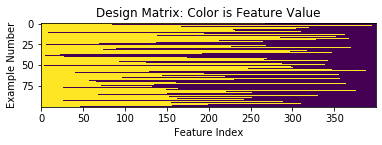

Hoping this is very close to 0:4.6884282980897267e-11
    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422


/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:197: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:220: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


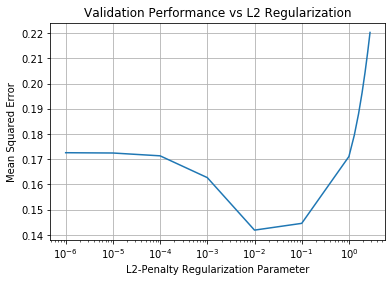

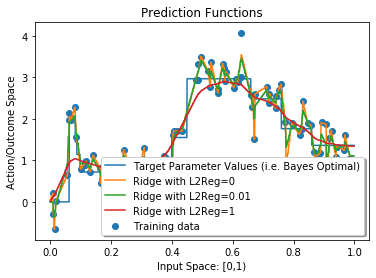

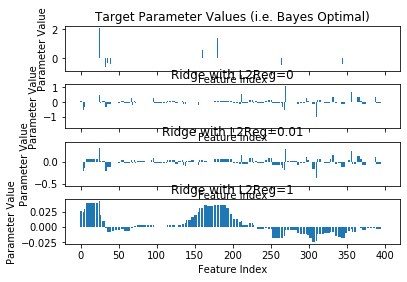

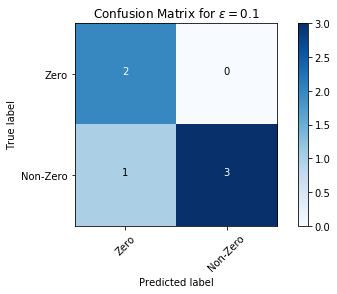

In [205]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools

from setup_problem import load_problem


class RidgeRegression(BaseEstimator, RegressorMixin):
	""" ridge regression"""

	def __init__(self, l2reg=1):
		if l2reg < 0:
			raise ValueError('Regularization penalty should be at least 0.')
		self.l2reg = l2reg

	def fit(self, X, y=None):
		n, num_ftrs = X.shape
		# convert y to 1-dim array, in case we're given a column vector
		y = y.reshape(-1)
		def ridge_obj(w):
			predictions = np.dot(X,w)
			residual = y - predictions
			empirical_risk = np.sum(residual**2) / n
			l2_norm_squared = np.sum(w**2)
			objective = empirical_risk + self.l2reg * l2_norm_squared
			return objective
		self.ridge_obj_ = ridge_obj

		w_0 = np.zeros(num_ftrs)
		self.w_ = minimize(ridge_obj, w_0).x
		return self

	def predict(self, X, y=None):
		try:
			getattr(self, "w_")
		except AttributeError:
			raise RuntimeError("You must train classifer before predicting data!")
		return np.dot(X, self.w_)

	def score(self, X, y):
		# Average square error
		try:
			getattr(self, "w_")
		except AttributeError:
			raise RuntimeError("You must train classifer before predicting data!")
		residuals = self.predict(X) - y
		return np.dot(residuals, residuals)/len(y)



def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
	# First run sklearn ridge regression and extract the coefficients
	from sklearn.linear_model import Ridge
	# Fit with sklearn -- need to multiply l2_reg by sample size, since their
	# objective function has the total square loss, rather than average square
	# loss.
	n = X_train.shape[0]
	sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
	sklearn_ridge.fit(X_train, y_train)
	sklearn_ridge_coefs = sklearn_ridge.coef_

	# Now run our ridge regression and compare the coefficients to sklearn's
	ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
	ridge_regression_estimator.fit(X_train, y_train)
	our_coefs = ridge_regression_estimator.w_

	print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
	# Now let's use sklearn to help us do hyperparameter tuning
	# GridSearchCv.fit by default splits the data into training and
	# validation itself; we want to use our own splits, so we need to stack our
	# training and validation sets together, and supply an index
	# (validation_fold) to specify which entries are train and which are
	# validation.
	X_train_val = np.vstack((X_train, X_val))
	y_train_val = np.concatenate((y_train, y_val))
	val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

	# Now we set up and do the grid search over l2reg. The np.concatenate
	# command illustrates my search for the best hyperparameter. In each line,
	# I'm zooming in to a particular hyperparameter range that showed promise
	# in the previous grid. This approach works reasonably well when
	# performance is convex as a function of the hyperparameter, which it seems
	# to be here.
	param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
										   np.arange(1,3,.3)
											 ))) }]

	ridge_regression_estimator = RidgeRegression()
	grid = GridSearchCV(ridge_regression_estimator,
						param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
	grid.fit(X_train_val, y_train_val)

	df = pd.DataFrame(grid.cv_results_)
	# Flip sign of score back, because GridSearchCV likes to maximize,
	# so it flips the sign of the score if "greater_is_better=FALSE"
	df['mean_test_score'] = -df['mean_test_score']
	df['mean_train_score'] = -df['mean_train_score']
	cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
	df_toshow = df[cols_to_keep].fillna('-')
	df_toshow = df_toshow.sort_values(by=["param_l2reg"])
	return grid, df_toshow

def compare_parameter_vectors(pred_fns):
	# Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
	# "coefs" key
	fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
	num_ftrs = len(pred_fns[0]["coefs"])
	for i in range(len(pred_fns)):
		title = pred_fns[i]["name"]
		coef_vals = pred_fns[i]["coefs"]
		axs[i].bar(range(num_ftrs), coef_vals)
		axs[i].set_xlabel('Feature Index')
		axs[i].set_ylabel('Parameter Value')
		axs[i].set_title(title)

	fig.subplots_adjust(hspace=0.3)
	return fig

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
	# Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
	# "preds" key. The value corresponding to the "preds" key is an array of
	# predictions corresponding to the input vector x. x_train and y_train are
	# the input and output values for the training data
	fig, ax = plt.subplots()
	ax.set_xlabel('Input Space: [0,1)')
	ax.set_ylabel('Action/Outcome Space')
	ax.set_title("Prediction Functions")
	plt.scatter(x_train, y_train, label='Training data')
	for i in range(len(pred_fns)):
		ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
	legend = ax.legend(loc=legend_loc, shadow=True)
	return fig

def plot_confusion_matrix(cm, title, classes):      
	 plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)     
	 plt.title(title)       
	 plt.colorbar()     
	 tick_marks = np.arange(len(classes))       
	 plt.xticks(tick_marks, classes, rotation=45)       
	 plt.yticks(tick_marks, classes)        

	 thresh = cm.max() / 2.        
	 for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):     
		 plt.text(j, i, format(cm[i, j], 'd'),      
				  horizontalalignment="center",     
				  color="white" if cm[i, j] > thresh else "black")      

	 plt.tight_layout()        
	 plt.ylabel('True label')       
	 plt.xlabel('Predicted label')

def main():
	lasso_data_fname = "lasso_data.pickle"
	x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

	# Generate features
	X_train = featurize(x_train)
	X_val = featurize(x_val)

	#Visualize training data
	fig, ax = plt.subplots()
	ax.imshow(X_train)
	ax.set_title("Design Matrix: Color is Feature Value")
	ax.set_xlabel("Feature Index")
	ax.set_ylabel("Example Number")
	plt.show(block=False)

	# Compare our RidgeRegression to sklearn's.
	compare_our_ridge_with_sklearn(X_train, y_train, l2_reg = 1.5)

	# Do hyperparameter tuning with our ridge regression
	grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
	print(results)

	# Plot validation performance vs regularization parameter
	fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
	ax.semilogx(results["param_l2reg"], results["mean_test_score"])
	ax.grid()
	ax.set_title("Validation Performance vs L2 Regularization")
	ax.set_xlabel("L2-Penalty Regularization Parameter")
	ax.set_ylabel("Mean Squared Error")
	fig.show()

	# Let's plot prediction functions and compare coefficients for several fits
	# and the target function.
	pred_fns = []
	x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
	name = "Target Parameter Values (i.e. Bayes Optimal)"
	pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

	l2regs = [0, grid.best_params_['l2reg'], 1]
	X = featurize(x)
	for l2reg in l2regs:
		ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
		ridge_regression_estimator.fit(X_train, y_train)
		name = "Ridge with L2Reg="+str(l2reg)
		pred_fns.append({"name":name,
						 "coefs":ridge_regression_estimator.w_,
						 "preds": ridge_regression_estimator.predict(X) })

	f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
	f.show()

	f = compare_parameter_vectors(pred_fns)
	f.show()


	##Sample code for plotting a matrix
	## Note that this is a generic code for confusion matrix
	## You still have to make y_true and y_pred by thresholding as per the insturctions in the question.
	y_true = [1, 0, 1, 1, 0, 1]
	y_pred = [0, 0, 1, 1, 0, 1]
	eps = 1e-1;
	cnf_matrix = confusion_matrix(y_true, y_pred)
	plt.figure()
	plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])
	plt.show()

if __name__ == '__main__':
  main()






In [83]:
def do_grid_search_ridge(X_train, y_train, X_val, y_val):
	# Now let's use sklearn to help us do hyperparameter tuning
	# GridSearchCv.fit by default splits the data into training and
	# validation itself; we want to use our own splits, so we need to stack our
	# training and validation sets together, and supply an index
	# (validation_fold) to specify which entries are train and which are
	# validation.
	X_train_val = np.vstack((X_train, X_val))
	y_train_val = np.concatenate((y_train, y_val))
	val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

	# Now we set up and do the grid search over l2reg. The np.concatenate
	# command illustrates my search for the best hyperparameter. In each line,
	# I'm zooming in to a particular hyperparameter range that showed promise
	# in the previous grid. This approach works reasonably well when
	# performance is convex as a function of the hyperparameter, which it seems
	# to be here.
	param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
										   np.arange(1,3,.3)
											 ))) }]

	ridge_regression_estimator = RidgeRegression()
	grid = GridSearchCV(ridge_regression_estimator,
						param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
	grid.fit(X_train_val, y_train_val)

	df = pd.DataFrame(grid.cv_results_)
	# Flip sign of score back, because GridSearchCV likes to maximize,
	# so it flips the sign of the score if "greater_is_better=FALSE"
	df['mean_test_score'] = -df['mean_test_score']
	df['mean_train_score'] = -df['mean_train_score']
	cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
	df_toshow = df[cols_to_keep].fillna('-')
	df_toshow = df_toshow.sort_values(by=["param_l2reg"])
	return grid, df_toshow

In [7]:
import matplotlib.pyplot as plt

In [8]:
def load_problem(file_name):
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return reconstitute_problem(data["coefs_true"], data["x_train"], data["y_train"],
                                data["x_test"], data["y_test"])


In [9]:
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem('lasso_data.pickle')
X_train = featurize(x_train)
X_val = featurize(x_val)

In [87]:

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
	# Now let's use sklearn to help us do hyperparameter tuning
	# GridSearchCv.fit by default splits the data into training and
	# validation itself; we want to use our own splits, so we need to stack our
	# training and validation sets together, and supply an index
	# (validation_fold) to specify which entries are train and which are
	# validation.
	X_train_val = np.vstack((X_train, X_val))
	y_train_val = np.concatenate((y_train, y_val))
	val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

	# Now we set up and do the grid search over l2reg. The np.concatenate
	# command illustrates my search for the best hyperparameter. In each line,
	# I'm zooming in to a particular hyperparameter range that showed promise
	# in the previous grid. This approach works reasonably well when
	# performance is convex as a function of the hyperparameter, which it seems
	# to be here.
	param_grid = [{'l2reg':10.**np.arange(-3,-1,0.2)}]

	ridge_regression_estimator = RidgeRegression()
	grid = GridSearchCV(ridge_regression_estimator,
						param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
	grid.fit(X_train_val, y_train_val)

	df = pd.DataFrame(grid.cv_results_)
	# Flip sign of score back, because GridSearchCV likes to maximize,
	# so it flips the sign of the score if "greater_is_better=FALSE"
	df['mean_test_score'] = -df['mean_test_score']
	df['mean_train_score'] = -df['mean_train_score']
	cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
	df_toshow = df[cols_to_keep].fillna('-')
	df_toshow = df_toshow.sort_values(by=["param_l2reg"])
	return grid, df_toshow

In [88]:
grid,df_toshow=do_grid_search_ridge(X_train, y_train, X_val, y_val)

Text(0.5, 0, 'L2 regularization parameter values')

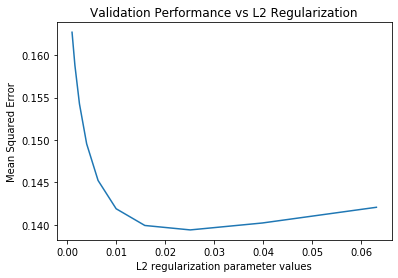

In [89]:
plt.plot(df_toshow['param_l2reg'],df_toshow['mean_test_score'])
plt.title("Validation Performance vs L2 Regularization")
plt.ylabel('Mean Squared Error')
plt.xlabel('L2 regularization parameter values') 

In [90]:
df_toshow

,param_l2reg,mean_test_score,mean_train_score
0,0.001000,0.162705,0.008285
1,0.001585,0.158797,0.009925
2,0.002512,0.154260,0.012853
3,0.003981,0.149546,0.017533
4,0.006310,0.145225,0.024202
5,0.010000,0.141887,0.032767
6,0.015849,0.139916,0.042934
7,0.025119,0.139392,0.054400
8,0.039811,0.140208,0.066953
9,0.063096,0.142061,0.080470


In [213]:

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
	# Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
	# "preds" key. The value corresponding to the "preds" key is an array of
	# predictions corresponding to the input vector x. x_train and y_train are
	# the input and output values for the training data
	fig, ax = plt.subplots()
	ax.set_xlabel('Input Space: [0,1)')
	ax.set_ylabel('Action/Outcome Space')
	ax.set_title("Prediction Functions")
	plt.scatter(x_train, y_train, label='Training data')
	x=np.sort(x_train)
	for i in range(len(pred_fns)):
		ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
	legend = ax.legend(loc=legend_loc, shadow=True)
	return fig

/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


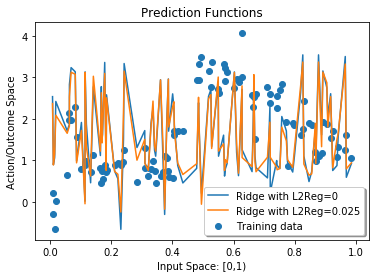

In [214]:
pred_fns = []
l2regs = [0, 0.025]
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X_train) })
f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
f.show()


 We observe that as the magnitude of regularization increases, we could expect a low estimation error with an high
 approximation error. The featurized vector I(x<0.62) has the most weight based on the previous plot.

In [93]:
def plot_confusion_matrix(cm, title, classes):      
	 plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)     
	 plt.title(title)       
	 plt.colorbar()     
	 tick_marks = np.arange(len(classes))       
	 plt.xticks(tick_marks, classes, rotation=45)       
	 plt.yticks(tick_marks, classes)        

	 thresh = cm.max() / 2.        
	 for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):     
		 plt.text(j, i, format(cm[i, j], 'd'),      
				  horizontalalignment="center",     
				  color="white" if cm[i, j] > thresh else "black")      

	 plt.tight_layout()        
	 plt.ylabel('True label')       
	 plt.xlabel('Predicted label')

In [95]:
epsilon=[10**-6,10**-3,10**-1]
sparse_list=[]
new_list=[]
for i in epsilon:
    coef_list=pred_fns[2]['coefs']
    coef_list[np.absolute(coef_list)<i]=0
 
    

In [126]:
sparse_list=[]
for i in epsilon:
    new_list=coef_list.copy()
    abs_list=np.absolute(new_list)
    new_list[abs_list<i]=0
    sparse_list.append(new_list)

In [127]:
beta_true=np.ones(400)
new_list=[]
for j in sparse_list:
    temp_list=j.copy()
    temp_list[temp_list!=0]=1
    new_list.append(temp_list)

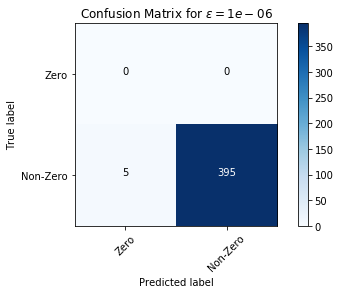

In [118]:
beta_true = np.ones(400)
beta_pred = new_list[0]
eps = 1e-6;
cnf_matrix = confusion_matrix(beta_true, beta_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])
plt.show()

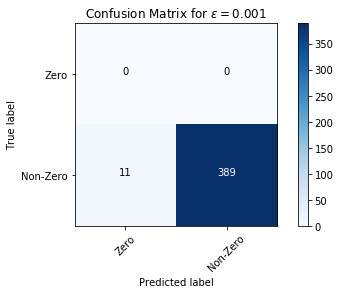

In [120]:
beta_true = np.ones(400)
beta_pred = new_list[1]
eps = 1e-3;
cnf_matrix = confusion_matrix(beta_true, beta_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])
plt.show()

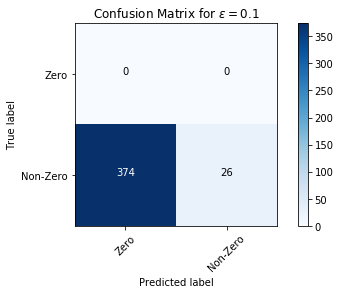

In [121]:
beta_true = np.ones(400)
beta_pred = new_list[2]
eps = 1e-1;
cnf_matrix = confusion_matrix(beta_true, beta_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])
plt.show()

 As we increase the mangitude of epsilon, we are setting more coeffiencts to 0. As observed from the previous confusion matrices, the False negative error increases if we do so. 

## Coordinate Descent for Lasso

$a_j=2{X_j}^TX_j$  
$c_j=2({X_j}^T(y-Xw)+w_j{X_j}^TX_j)$

In [57]:
def lambda_max(X,y):
    lambda_max=2*np.amax(np.absolute(np.dot(X.T,y)))
    return lambda_max

In [58]:
def ridge_regression_solution(X,y,lambda_reg):
    lambda_array=np.ones(X.shape[1])*lambda_reg
    inver_part=np.linalg.inv(np.dot(X.T,X)+np.diag(lambda_array))
    part=np.dot(X.T,y)
    w=np.dot(inver_part,part)
    return w

In [59]:
def cyclic_coordinate_descent(X,y,w_coeff,lambda_reg):
    num_features=X.shape[1]
    a_list=np.zeros(num_features)
    c_list=np.zeros(num_features)
    for i in range(num_features):
        a_list[i]=2*np.dot(X[:,i].T,X[:,i])
        pred=np.dot(X,w_coeff)
        c_list[i]=2*(np.dot(X[:,i].T,y-pred)+w_coeff[i]*np.dot(X[:,i].T,X[:,i]))
        soft_indicator=np.abs(c_list[i]/a_list[i])-lambda_reg/a_list[i]
        if soft_indicator>0:
            w_coeff[i]=np.sign(c_list[i]/a_list[i])*soft_indicator
        else:
            w_coeff[i]=0
    return w_coeff

In [115]:
def randomized_coordinate_descent(X,y,w_coeff,lambda_reg):
    num_features=X.shape[1]
    a_list=np.zeros(num_features)
    c_list=np.zeros(num_features)
    for i in range(num_features):
        j=np.random.randint(0,num_features,1)[0]
        a_list[i]=2*np.dot(X[:,j].T,X[:,j])
        pred=np.dot(X,w_coeff)
        c_list[i]=2*(np.dot(X[:,j].T,y-pred)+w_coeff[i]*np.dot(X[:,j].T,X[:,j]))
        soft_indicator=np.abs(c_list[i]/a_list[i])-lambda_reg/a_list[i]
        if soft_indicator>0:
            w_coeff[i]=np.sign(c_list[i]/a_list[i])*soft_indicator
        else:
            w_coeff[i]=0
    return w_coeff

In [82]:
def loss_function(X,y,w_coeff):
    num_instances=X.shape[0]
    pred=np.dot(X,w_coeff)
    bias=pred-y
    loss=np.dot(bias.T,bias)/num_instances
    return loss

In [116]:
def coordinate_descent_algorithm(X, y, method, lambda_reg, num_iter=1000):
    num_instances,num_features = X.shape[0],X.shape[1]
    w_coeff_zeros=np.zeros(num_features)
    w_coeff_ridge=ridge_regression_solution(X,y,lambda_reg)
    coeff_history=np.zeros((num_iter,num_features))
    ridge_coeff_history=np.zeros((num_iter,num_features))
    loss_zero=np.zeros(num_iter)
    loss_ridge=np.zeros(num_iter)
    for i in range(num_iter):
        if  method=='random':
            coeff_history[i]=w_coeff_zeros
            loss_zero[i]=loss_function(X,y,w_coeff_zeros)
            w_coeff_zeros=randomized_coordinate_descent(X,y,coeff_history[i],lambda_reg)
           
            
            ridge_coeff_history[i]=w_coeff_ridge
            loss_ridge[i]=loss_function(X,y,w_coeff_ridge)
            w_coeff_ridge=randomized_coordinate_descent(X,y,ridge_coeff_history[i],lambda_reg)
            
        else:
            coeff_history[i]=w_coeff_zeros
            loss_zero[i]=loss_function(X,y,w_coeff_zeros)
            w_coeff_zeros=cyclic_coordinate_descent(X,y,coeff_history[i],lambda_reg)
            
            ridge_coeff_history[i]=w_coeff_ridge
            loss_ridge[i]=loss_function(X,y,w_coeff_ridge)
            w_coeff_ridge=cyclic_coordinate_descent(X,y,ridge_coeff_history[i],lambda_reg)
    
    return w_coeff_zeros, coeff_history, loss_zero, w_coeff_ridge, ridge_coeff_history,loss_ridge

/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


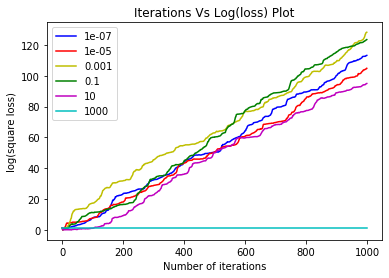

In [117]:
lambda_set=[10**i for i in range(-7,4,2)]
train_zero_loss=np.zeros((len(lambda_set),1000))
for i in range(len(lambda_set)):
    train_zero_loss[i]=coordinate_descent_algorithm(X_train, y_train, 'random', lambda_set[i], num_iter=1000)[2]
    
color_set=['b-','r-','y-','g-','m-','c-']
for i in range(6):
    plt.plot(range(1000),np.log(train_zero_loss[i]),color_set[i],label=lambda_set[i])
    plt.legend(loc='best')
    

plt.ylabel('log(square loss)')
plt.xlabel('Number of iterations')  
plt.title("Iterations Vs Log(loss) Plot")
plt.show()  

/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


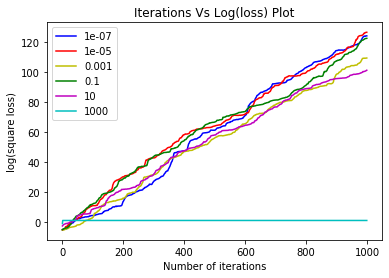

In [123]:
lambda_set=[10**i for i in range(-7,4,2)]
ridge_zero_loss=np.zeros((len(lambda_set),1000))
for i in range(len(lambda_set)):
    ridge_zero_loss[i]=coordinate_descent_algorithm(X_train, y_train, 'random', lambda_set[i], num_iter=1000)[5]
    
color_set=['b-','r-','y-','g-','m-','c-']
for i in range(6):
    plt.plot(range(1000),np.log(ridge_zero_loss[i]),color_set[i],label=lambda_set[i])
    plt.legend(loc='best')
    

plt.ylabel('log(square loss)')
plt.xlabel('Number of iterations')  
plt.title("Iterations Vs Log(loss) Plot")
plt.show()  

/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


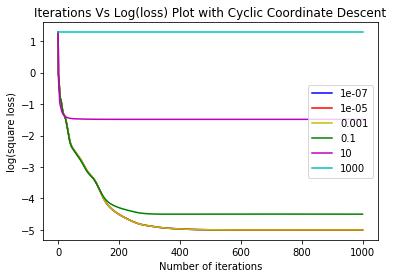

In [118]:
lambda_set=[10**i for i in range(-7,4,2)]
train_cyclic_loss=np.zeros((len(lambda_set),1000))
for i in range(len(lambda_set)):
    train_cyclic_loss[i]=coordinate_descent_algorithm(X_train, y_train, 'cyclic', lambda_set[i], num_iter=1000)[2]
    
color_set=['b-','r-','y-','g-','m-','c-']
for i in range(6):
    plt.plot(range(1000),np.log(train_cyclic_loss[i]),color_set[i],label=lambda_set[i])
    plt.legend(loc='best')
    

plt.ylabel('log(square loss)')
plt.xlabel('Number of iterations')  
plt.title("Iterations Vs Log(loss) Plot with Cyclic Coordinate Descent")
plt.show()  

/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


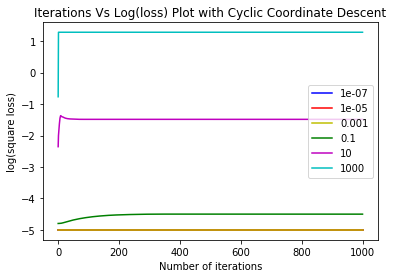

In [122]:
lambda_set=[10**i for i in range(-3,0,1)]
ridge_cyclic_loss=np.zeros((len(lambda_set),1000))
for i in range(len(lambda_set)):
    ridge_cyclic_loss[i]=coordinate_descent_algorithm(X_train, y_train, 'cyclic', lambda_set[i], num_iter=1000)[5]
    
color_set=['b-','r-','y-','g-','m-','c-']
for i in range(6):
    plt.plot(range(1000),np.log(ridge_cyclic_loss[i]),color_set[i],label=lambda_set[i])
    plt.legend(loc='best')
    

plt.ylabel('log(square loss)')
plt.xlabel('Number of iterations')  
plt.title("Iterations Vs Log(loss) Plot with Cyclic Coordinate Descent")
plt.show()  

Ridge solution converges faster than $w$ starting with 0 

In [165]:
import pandas as pd
lambda_set=10.**np.arange(-3,-1,0.2)
train_loss=np.zeros(10)
test_loss=np.zeros(10)
for i in range(len(lambda_set)):
    train_loss[i]=coordinate_descent_algorithm(X_train, y_train, 'cyclic', lambda_set[i], num_iter=1000)[2][-1]
    test_loss[i]=coordinate_descent_algorithm(X_val, y_val, 'cyclic', lambda_set[i], num_iter=1000)[2][-1]

/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


NameError: name 'lamba_set' is not defined

In [167]:

# Creating an empty Dataframe with column names only
df_toshow= pd.DataFrame(columns=['reg_val', 'train_loss', 'test_loss'])
df_toshow['reg_val']=lambda_set
df_toshow['train_loss']=train_loss
df_toshow['test_loss']=test_loss
df_toshow

,reg_val,train_loss,test_loss
0,0.001000,0.006752,0.053161
1,0.001585,0.006753,0.053161
2,0.002512,0.006755,0.053162
3,0.003981,0.006761,0.053165
4,0.006310,0.006773,0.053169
5,0.010000,0.006805,0.053177
6,0.015849,0.006885,0.053196
7,0.025119,0.007085,0.053240
8,0.039811,0.007564,0.053341
9,0.063096,0.008643,0.053578


Text(0.5, 0, 'L1 regularization parameter values')

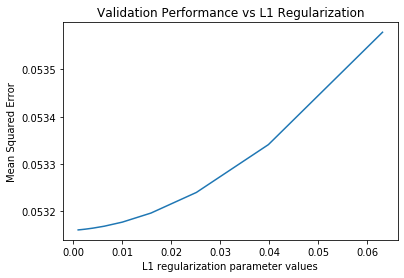

In [172]:
plt.plot(df_toshow['reg_val'],df_toshow['test_loss'])
plt.title("Validation Performance vs L1 Regularization")
plt.ylabel('Mean Squared Error')
plt.xlabel('L1 regularization parameter values') 

In [208]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
	# Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
	# "preds" key. The value corresponding to the "preds" key is an array of
	# predictions corresponding to the input vector x. x_train and y_train are
	# the input and output values for the training data
	fig, ax = plt.subplots()
	ax.set_xlabel('Input Space: [0,1)')
	ax.set_ylabel('Action/Outcome Space')
	ax.set_title("Prediction Functions")
	plt.scatter(x_train, y_train, label='Training data')
	x=np.sort(x_train)  
	for i in range(len(pred_fns)):
		ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
	legend = ax.legend(loc=legend_loc, shadow=True)
	return fig

/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


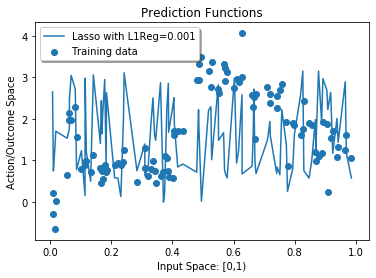

In [215]:
pred_fns = []
l1reg = 0.001
w_coeff=coordinate_descent_algorithm(X_val, y_val, 'cyclic', l1reg, num_iter=1000)[0]
y_pred=np.dot(X_train,w_coeff)
name = "Lasso with L1Reg="+str(l1reg)
pred_fns.append({"name":name,
                         "coefs":w_coeff,
                         "preds":y_pred })
f = plot_prediction_functions(x_train, pred_fns, x_train, y_train, legend_loc="best")
f.show()

/home/linxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


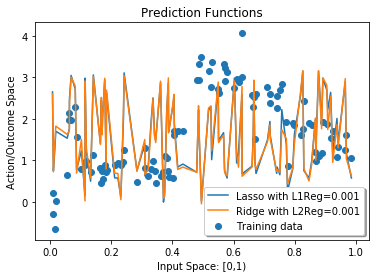

In [228]:
l2reg=0.001
ridge_regression_estimator = RidgeRegression(l2reg=0.001)
ridge_regression_estimator.fit(X_val, y_val)
name = "Ridge with L2Reg="+str(l2reg)
pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X_train) })
f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
f.show()

In [239]:
def sparsity_epsilon_fn(epsilon,coeff_list):
    sparse_list=[]
    for i in epsilon:
        new_list=coeff_list.copy()
        abs_list=np.absolute(new_list)
        new_list[abs_list<i]=0
        new_list=list(new_list)
        sparsity=new_list.count(0)
        sparse_list.append(sparsity)
    return sparse_list

In [240]:
epsilon=[10**-6,10**-3,10**-1]
lasso_coeff=pred_fns[0]['coefs']
ridge_coeff=pred_fns[1]['coefs']
print(sparsity_epsilon_fn(epsilon,lasso_coeff))
print(sparsity_epsilon_fn(epsilon,ridge_coeff))

[44, 44, 152]
[0, 4, 241]


Based on this result, lasso regression gives a more sparse representation of parameters $w$ than ridge regression

In [246]:
homotopy_set=lambda_max(X_val,y_val)*0.8**np.arange(0,30,1)
val_loss=np.zeros(30)
for i in range(len(homotopy_set)):
    val_loss[i]=coordinate_descent_algorithm(X_val, y_val, 'cyclic', homotopy_set[i], num_iter=1000)[2][-1]

In [250]:
# Creating an empty Dataframe with column names only
df_toshow= pd.DataFrame(columns=['reg_val', 'val_loss'])
df_toshow['reg_val']=homotopy_set
df_toshow['val_loss']=val_loss
df_toshow

,reg_val,val_loss
0,2921.944233,3.576553
1,2337.555387,2.565291
2,1870.044309,1.915569
3,1496.035447,1.472566
4,1196.828358,1.072539
5,957.462686,0.813984
6,765.970149,0.648263
7,612.776119,0.541102
8,490.220895,0.467082
9,392.176716,0.419400


Text(0.5, 0, 'L1 regularization homotopy values')

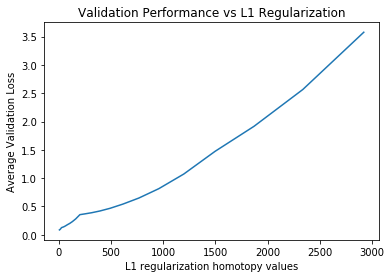

In [251]:
plt.plot(df_toshow['reg_val'],df_toshow['val_loss'])
plt.title("Validation Performance vs L1 Regularization")
plt.ylabel('Average Validation Loss')
plt.xlabel('L1 regularization homotopy values') 